## 1) Give an overall summary of your performance from HW2 on the dataset

Overall, my performance was positive. The accuracy, in every case, performed over the minimal benchmark (~65%). My worst model, Naive Bayes (multinomial) performed at 70.25% at ~79.7 microsec with the pg_conc feature. The model I chose as best when considering interpretibility, speed, and accuracy together was Logistic Regression at 76.16% for both all_data (data_imputed) at ~31.2 microsec per loop and data_small (data_dropped) at ~31.3 microsec per loop. I tested three different datasets for a dropped feature, imputed missing values, and an engineered feature. Of course, there were definitely some areas for improvement (see below).

## 2) Do you see any areas for improvement?

One main area for improvement could have been in how I measured for accuracy and instead should have used recall, F1, or AUC as there was unbalance in the class results and we were predicting medical outcomes. I also could have used gaussian Naive Bayes instead of multinomial Naive Bayes given the numerical nature of the data. Additionally, I could have spent more time playing around with tuning. Further, learning curves for several models revealed bias in most of the results.

## 3) Run k-Means on the dataset and describe your results

- Inertia/Silhouette: 
    - (1) DATA_IMPUTED: Inertia score: 2422.97815686  / Silhouette score: 0.143477347606
    - (2) DATA_FENGINEERED: Inertia score: 2763.42249348  / Silhouette score: 0.12987366144
    - (3) DATA_DROPPED: Inertia score: 2290.3527396 / Silhouette score: 0.137652896944
- Speed: (1) ~118 ms per loop with data_imputed (2) ~115 ms per loop with data_fengineered (3) ~186 ms per loop with data_dropped
- Explored: DATA_DROPPED since it balances the lowest inertia score with one of the highest silhouette scores (still not very close to 1, unfortunately)
- Comments: Breaking the data into clusters was interesting, since we can see that certain groups are definitely more at risk ('Early-Thirties in Need of Lifestyle Change') than others ('Carefree, Stick-Thin Twenty-Somesomethings'), implying that we have found distinct clusters. The low silhouette score implies that there are possibly better groupings available, although we need to feed the results through a supervised model to truly evaluate its usefulness.

In [256]:
# import necessary libraries to start
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [257]:
# import data (exported from hw2)
data_imputed = pd.read_csv('data_imputed.csv')
data_fengineered = pd.read_csv('data_fengineered.csv')
data_dropped = pd.read_csv('data_dropped.csv')

In [258]:
# check that I've imported the data correctly
data_fengineered.head()

,preg,pg_conc,diastolic_bp,skin,serum_insulin,bmi,diabetes_pf,age,class,ratio
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,1.184
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,0.680
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,1.464
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,0.947
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,0.815


In [259]:
# check that it's all there
data_fengineered.shape

(752, 10)

In [260]:
data_fengineered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 752 entries, 0 to 751
Data columns (total 10 columns):
preg             752 non-null int64
pg_conc          752 non-null float64
diastolic_bp     752 non-null float64
skin             752 non-null float64
serum_insulin    752 non-null float64
bmi              752 non-null float64
diabetes_pf      752 non-null float64
age              752 non-null int64
class            752 non-null int64
ratio            752 non-null float64
dtypes: float64(7), int64(3)
memory usage: 64.6 KB


### REMINDER: Data Dictionary (describes the features):
[reference](https://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes)
<table>
    <tr>
        <td>**Field Name**</td>
        <td>**Type**</td>
        <td>**Description**</td>
    </tr>
    <tr>
        <td>preg</td>
        <td>integer</td>
        <td>Number of times pregnant</td>
    </tr>
    <tr>
        <td>pg_conc</td>
        <td>integer</td>
        <td>Plasma glucose concentration a[t] 2 hours in an oral glucose tolerance test
        <br>(units not given, but maybe mg/dL)</td>
    </tr>
    <tr>
        <td>diastolic_bp</td>
        <td>integer</td>
        <td>Diastolic blood pressure (mm Hg)</td>
    </tr>
    <tr>
        <td>skin</td>
        <td>integer</td>
        <td>Triceps skin fold thickness (mm)</td>
    </tr>
    <tr>
        <td>serum_insulin</td>
        <td>integer</td>
        <td>2-Hour serum insulin (mu U/ml)</td>
    </tr>
    <tr>
        <td>bmi</td>
        <td>float</td>
        <td>Body mass index (weight in kg/(height in m)^2)</td>
    </tr>
    <tr>
        <td>diabetes_pf</td>
        <td>float</td>
        <td>Diabetes pedigree function</td>
    </tr>
    <tr>
        <td>age</td>
        <td>integer</td>
        <td>Age (years)</td>
    </tr>
    <tr>
        <td>class</td>
        <td>integer (0 or 1)</td>
        <td>Class variable (0 to signify no diabetes or 1 to signify diabetes)</td>
    </tr>
    <tr>
        <td>ratio</td>
        <td>float</td>
        <td>New feature I created, tested in one of the dataframes (datar):  pg_conc/serum_insulin
        <br>Ratio of plasma glucose in blood after two hour test to serum insulin after two hour test
        <br>(see end of Heading 3 for creation)</br>
        </td>
    </tr>
</table>
        
        




In [261]:
# convert class feature to categorical 
data_imputed['class'] = pd.Categorical(data_imputed['class'])
data_fengineered['class'] = pd.Categorical(data_fengineered['class'])
data_dropped['class'] = pd.Categorical(data_dropped['class'])

In [262]:
# Assign data to X and y (3x for each dataset I wish to test)
y1 = data_imputed['class']
y2 = data_fengineered['class']
y3 = data_dropped['class']

X1 = data_imputed.drop('class', axis=1)
X2 = data_fengineered.drop('class', axis=1)
X3 = data_dropped.drop('class', axis=1)

In [263]:
# break up the data into test and training sets:
from sklearn.cross_validation import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=1)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2, random_state=1)

In [264]:
# 20% test / 80% train / 10 cross validation iterations 
from sklearn.cross_validation import ShuffleSplit
cv1 = ShuffleSplit(X_train1.shape[0], n_iter=10, test_size=0.2, random_state=0)
cv2 = ShuffleSplit(X_train2.shape[0], n_iter=10, test_size=0.2, random_state=0)
cv3 = ShuffleSplit(X_train3.shape[0], n_iter=10, test_size=0.2, random_state=0)

In [265]:
from sklearn.preprocessing import StandardScaler
# standardize training features
scale = StandardScaler()
X_train_std1 = scale.fit_transform(X_train1)
# standardize the testing features in the same way - needed?
X_test_std1 = scale.fit_transform(X_test1)

X_train_std2 = scale.fit_transform(X_train2)
X_test_std2 = scale.fit_transform(X_test2)

X_train_std3 = scale.fit_transform(X_train3)
X_test_std3 = scale.fit_transform(X_test3)

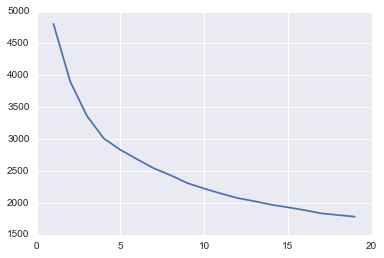

In [266]:
from sklearn.cluster import KMeans

# look at inertia plot (how close together are the points in the clusters) -- data_imputed
x = []
y = []
for n in range(1,20):
    km11 = KMeans(n_clusters=n)
    km11.fit(X_train_std1)
    x.append(n)
    y.append(km11.inertia_)
plt.plot(x, y);

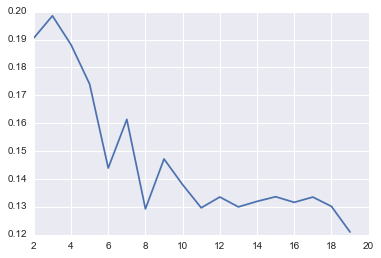

In [267]:
from sklearn.metrics import silhouette_score

# look at silhouette plot (density and separation of each cluster) -- data_imputed
x = []
y = []
for n in range(2,20):
    km11 = KMeans(n_clusters=n)
    centers = km11.fit_predict(X_train_std1)
    x.append(n)
    y.append(silhouette_score(X_train_std1, centers))
plt.plot(x, y);

In [268]:
%%timeit
# I'm going to choose k=8
km1 = KMeans(n_clusters=8, n_init=20)
cluster_labels1 = km1.fit_predict(X_train_std1)

10 loops, best of 3: 118 ms per loop


In [269]:
km1 = KMeans(n_clusters=8, n_init=20)
cluster_labels1 = km1.fit_predict(X_train_std1)

In [270]:
print 'DATA_IMPUTED:\nInertia score: {} \nSilhouette score: {}'.format(km1.inertia_, silhouette_score(X_train_std1, cluster_labels1))

DATA_IMPUTED:
Inertia score: 2422.97815686 
Silhouette score: 0.143477347606


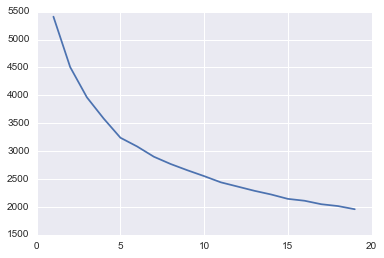

In [271]:
# look at inertia plot (how close together are the points in the clusters) -- data_fengineered
x = []
y = []
for n in range(1,20):
    km22 = KMeans(n_clusters=n)
    km22.fit(X_train_std2)
    x.append(n)
    y.append(km22.inertia_)
plt.plot(x, y);

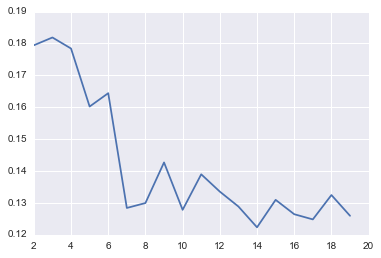

In [272]:
from sklearn.metrics import silhouette_score

# look at silhouette plot (density and separation of each cluster) -- data_fengineered
x = []
y = []
for n in range(2,20):
    km22 = KMeans(n_clusters=n)
    centers = km22.fit_predict(X_train_std2)
    x.append(n)
    y.append(silhouette_score(X_train_std2, centers))
plt.plot(x, y);

In [273]:
%%timeit
# I'm going to choose k=8
km2 = KMeans(n_clusters=8, n_init=20)
cluster_labels2 = km2.fit_predict(X_train_std2)

10 loops, best of 3: 115 ms per loop


In [274]:
km2 = KMeans(n_clusters=8, n_init=20)
cluster_labels2 = km2.fit_predict(X_train_std2)

In [275]:
print 'DATA_FENGINEERED:\nInertia score: {} \nSilhouette score: {}'.format(km2.inertia_, silhouette_score(X_train_std2, cluster_labels1))

DATA_FENGINEERED:
Inertia score: 2763.42249348 
Silhouette score: 0.12987366144


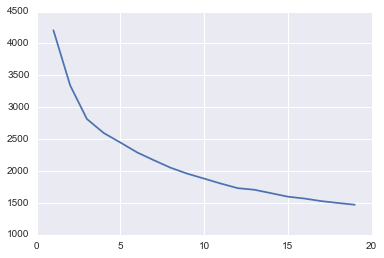

In [276]:
# look at inertia plot (how close together are the points in the clusters) -- data_dropped
x = []
y = []
for n in range(1,20):
    km33 = KMeans(n_clusters=n)
    km33.fit(X_train_std3)
    x.append(n)
    y.append(km33.inertia_)
plt.plot(x, y);

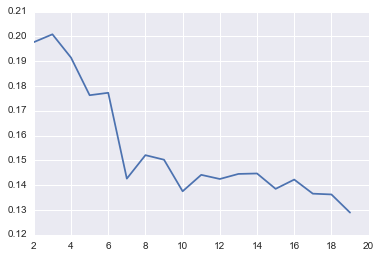

In [277]:
# look at silhouette plot (density and separation of each cluster) -- data_dropped
x = []
y = []
for n in range(2,20):
    km33 = KMeans(n_clusters=n)
    centers = km33.fit_predict(X_train_std3)
    x.append(n)
    y.append(silhouette_score(X_train_std3, centers))
plt.plot(x, y);

In [278]:
%%timeit
# I'm going to choose k=6
km3 = KMeans(n_clusters=6, n_init=20)
cluster_labels3 = km3.fit_predict(X_train_std3)

1 loops, best of 3: 186 ms per loop


In [279]:
km3 = KMeans(n_clusters=6, n_init=20)
cluster_labels3 = km3.fit_predict(X_train_std3)

In [280]:
print 'DATA_DROPPED:\nInertia score: {} \nSilhouette score: {}'.format(km3.inertia_, silhouette_score(X_train_std3, cluster_labels1))

DATA_DROPPED:
Inertia score: 2290.3527396 
Silhouette score: 0.137652896944


In [281]:
# check cluster centers for each cluster
pd.set_option('display.float_format', lambda x: '%.3f' % x)
columns = {str(x): scale.inverse_transform(km3.cluster_centers_[x]) for x in range(0,len(km3.cluster_centers_))}
pd.DataFrame(columns, index=X_train3.columns)

,0,1,2,3,4,5
preg,2.007,4.913,7.890,1.935,3.659,1.769
pg_conc,117.426,153.818,108.223,101.710,138.258,137.864
diastolic_bp,70.510,79.757,76.306,64.947,74.735,84.527
skin,31.663,27.907,31.882,19.757,34.421,41.963
bmi,33.097,30.172,32.056,25.310,35.045,41.944
diabetes_pf,0.375,0.391,0.392,0.409,1.169,0.429
age,26.324,47.424,40.958,24.739,33.223,27.817


In [282]:
# check stats for each feature for comparison
X_train3.describe()

,preg,pg_conc,diastolic_bp,skin,bmi,diabetes_pf,age
count,601.000,601.000,601.000,601.000,601.000,601.000,601.000
mean,3.923,121.963,72.153,29.043,32.674,0.473,33.507
std,3.459,30.677,12.110,8.602,6.937,0.330,11.891
min,0.000,57.000,24.000,7.000,18.200,0.078,21.000
25%,1.000,100.000,64.000,25.000,27.600,0.245,24.000
50%,3.000,117.000,72.000,29.000,32.400,0.380,29.000
75%,6.000,141.000,80.000,32.000,36.900,0.629,41.000
max,17.000,198.000,114.000,63.000,67.100,2.420,81.000


In [465]:
# Check cluster sizes
cluster_sizes = pd.DataFrame(data=[y_train3, cluster_labels3])
cluster_sizes.head()

,0,1
0,0,3
1,1,5
2,0,0
3,0,1
4,0,2


In [468]:
cluster_sizes = cluster_sizes.rename(columns=({ 0 : 'class', 1: 'cluster'}))

In [469]:
cluster_sizes.head()

,class,cluster
0,0,3
1,1,5
2,0,0
3,0,1
4,0,2


In [508]:
# view percentages of which clusters get diagnosed with diabetes more than others
cluster_sizes['class'] = cluster_sizes['class'].astype(int)
diabetes = cluster_sizes.groupby(['cluster'])['class'].mean()
diabetes

cluster
0   0.283
1   0.615
2   0.394
3   0.048
4   0.661
5   0.536
Name: class, dtype: float64

In [509]:
diabetes = pd.DataFrame(data=[cluster_sizes.groupby(['cluster'])['class'].mean()])
diabetes.head()

cluster,0,1,2,3,4,5
class,0.283,0.615,0.394,0.048,0.661,0.536


In [517]:
# Assign names/categories to each custer according to distinguishing characteristics
diabetes = diabetes.rename(columns=({ 0 : 'Young, Healthy, and Curvy', 1: 'Life-Experienced Ladies in Need of Zen',
                                               2 : 'Borderline-Healthy Many-Time Mothers', 3: 'Carefree, Stick-Thin Twenty-Somesomethings',
                                              4 : 'Early-Thirties in Need of Lifestyle Change', 5: 'Plus-Sized, Stressed, and Possibly Single'}))
diabetes.head()

cluster,"Young, Healthy, and Curvy",Life-Experienced Ladies in Need of Zen,Borderline-Healthy Many-Time Mothers,"Carefree, Stick-Thin Twenty-Somesomethings",Early-Thirties in Need of Lifestyle Change,"Plus-Sized, Stressed, and Possibly Single"
class,0.283,0.615,0.394,0.048,0.661,0.536


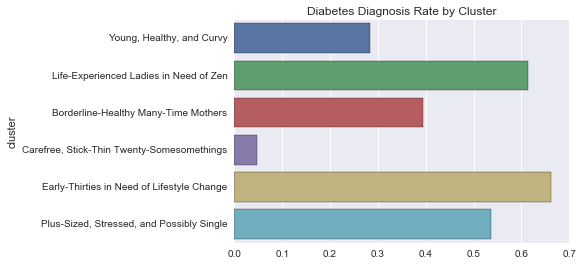

In [511]:
plt.title('Diabetes Diagnosis Rate by Cluster')
sns.barplot(data=diabetes, ci=None, orient='h', order=diabetes.columns);

In [470]:
cluster_sizes['cluster'].value_counts()

3    146
0    145
2     99
1     96
4     59
5     56
Name: cluster, dtype: int64

In [472]:
cluster_names = pd.DataFrame(data=[cluster_sizes['cluster'].value_counts()])
cluster_names.head()

,3,0,2,1,4,5
cluster,146,145,99,96,59,56


In [502]:
# Assign names/categories to each custer according to distinguishing characteristics
cluster_names = cluster_names.rename(columns=({ 0 : 'Young, Healthy, and Curvy', 1: 'Life-Experienced Ladies in Need of Zen',
                                               2 : 'Borderline-Healthy Many-Time Mothers', 3: 'Carefree, Stick-Thin Twenty-Somesomethings',
                                              4 : 'Early-Thirties in Need of Lifestyle Change', 5: 'Plus-Sized, Stressed, and Possibly Single'}))
cluster_names.head()

,"Carefree, Stick-Thin Twenty-Somesomethings","Young, Healthy, and Curvy",Borderline-Healthy Many-time Mothers,Life-Experienced Ladies in Need of Zen,Early-Thirties in Need of Lifestyle Change,"Plus-Sized, Stressed, and Possibly Single"
cluster,146,145,99,96,59,56


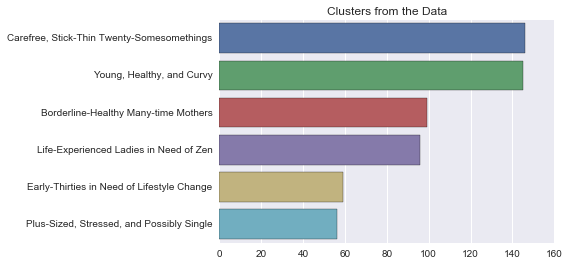

In [503]:
# graph the clusters
plt.title('Clusters from the Data')
sns.barplot(data=cluster_names, ci=None, orient='h', order=cluster_names.columns);

## 4) Run PCA on the dataset and describe your results

- Speed: 132 microseconds per loop with data_dropped to transform to test data
- Comments: With PCA, we went from seven to five features on the training set (remember: data_dropped does not include the serum_insulin feature). These five features explain approximately 88% of the variance.

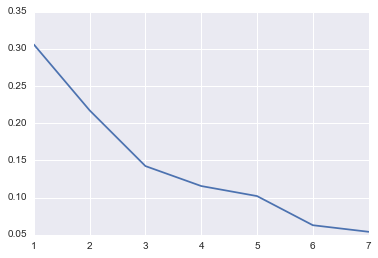

In [431]:
# plot all the features to find n_components
from sklearn.decomposition import PCA
pca = PCA(n_components=7)
pca.fit(X_train_std3)
plt.plot(range(1,8), pca.explained_variance_ratio_);

In [519]:
# ^looks like n_components should be 5
pca = PCA(n_components=5)

In [433]:
pca = PCA(n_components=5)
pca.fit(X_train_std3)

PCA(copy=True, n_components=5, whiten=False)

In [436]:
# first two components expain almost 90% of variance in the dataset
pca.explained_variance_ratio_

array([ 0.30581227,  0.21727536,  0.14237808,  0.11554721,  0.10205748])

In [435]:
sum(pca.explained_variance_ratio_)

0.88307040388193248

In [437]:
# Training data --> PCA (transform)
X_trainpca3 = pd.DataFrame(pca.transform(X_train_std3))

In [518]:
%%timeit
# Test data --> PCA (transform)
X_testpca3 = pd.DataFrame(pca.transform(X_test_std3))

The slowest run took 176.26 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 132 µs per loop


In [439]:
X_trainpca3.head()

,0,1,2,3,4
0,-3.556,-0.377,0.153,-0.634,0.311
1,0.501,2.218,-0.701,0.249,0.854
2,0.693,0.410,-1.405,-0.673,-0.044
3,1.087,-0.908,1.196,0.544,0.639
4,0.883,0.160,-0.062,-0.522,-1.282


## 5) Use the cluster outputs you got from running k-means as a new feature. Rerun your "worst" and "best" model from HW2, including this new feature along with your old features. Describe your results.

- Best model from HW2 based on accuracy: Logistic Regression with data_imputed
    - Speed: 87.9 microsecs per loop
    - Accuracy: 76.17% (Recall: 65.85%, F1: 60%)
    - Comments: Using k-means added over 50 microsecs to the runtime, which makes sense since we essentially added an extra dimension. That said, it did not impact the accuracy positively nor negatively. I would be curious to see if re-tuning the model would yield different results.
- Worst model from HW2 based on accuracy: Naive Bayes with data_imputed
    - Speed: 146 microsecs per loop (this is a little less than double the runtime of the multinomial non-k-means model).
    - Accuracy: 68.87% (Recall: 52%, F1: 52.25%)
    - Comments: Admittedly, this is not a direct apples-to-apples comparison, but it was interesting that performance declined with the gaussian model even with k-means as I had expected accuracy at least to increase (but might mean that the clusters aren't well-formed).

#### Logistic Regression with data_imputed - k-means

In [480]:
# add cluster labels to training set; make sure it is standardized and in a dataframe
X_kmtrain11 = X_train1.copy()
X_kmtrain11 = pd.DataFrame(scale.fit_transform(X_kmtrain11))
X_kmtrain11['cluster'] = km1.labels_
X_kmtrain11.head()

,0,1,2,3,4,5,6,7,cluster
0,-0.846,-1.663,-1.996,-1.285,-0.746,-1.771,-0.456,-0.969,5
1,-1.135,0.425,-0.343,1.507,1.177,1.389,-0.329,-0.800,4
2,-0.267,-0.847,0.483,1.158,-0.204,0.667,-0.714,0.546,1
3,0.601,1.404,-0.343,-0.354,0.271,0.134,0.478,1.304,7
4,0.601,-0.488,1.310,-0.005,-0.204,0.595,0.770,-0.211,3


In [483]:
# add cluster labels to test set; make sure it is standardized and in a dataframe
X_kmtest11 = X_test1.copy()
X_kmtest11 = pd.DataFrame(scale.fit_transform(X_kmtest11))
X_kmtest11['cluster'] = km1.predict(X_test_std1)
X_kmtest11.head()

,0,1,2,3,4,5,6,7,cluster
0,-0.854,-0.886,0.056,-0.863,-0.830,-0.832,0.608,0.317,5
1,-0.521,-0.721,-0.270,2.308,-1.055,1.306,0.620,-0.690,4
2,0.479,-2.570,-0.923,-0.045,-0.100,-0.964,0.348,0.317,5
3,-0.521,-0.556,0.138,-0.045,-0.100,-1.213,0.267,1.873,6
4,1.479,2.117,1.362,0.569,1.305,0.427,-0.147,0.409,6


In [485]:
# import and create classifier
# use same parameters from best-performing model: 'C': 1010.1010199999999, 'class_weight': None, 'penalty': 'l1'
from sklearn.linear_model import LogisticRegression
lrkm1 = LogisticRegression(C= 1010.1010199999999, class_weight= None, penalty='l1')
lrkm1.fit(X_kmtrain11, y_train1)

LogisticRegression(C=1010.10102, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0)

In [486]:
%timeit lrkm1.predict(X_kmtest11)

The slowest run took 30.56 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 87.9 µs per loop


In [487]:
# accuracy
lrkm1.score(X_kmtest11, y_test1)

0.76158940397350994

In [488]:
# Precision / Recall / F1
from sklearn.metrics import precision_recall_fscore_support

pred11 = lrkm1.predict(X_kmtest11)
precision_recall_fscore_support(pred11, y_test1, average='binary')   

(0.55102040816326525, 0.65853658536585369, 0.59999999999999998, None)

#### Naive Bayes with data_imputed - k-means

In [329]:
# Remember, I used the multinomial type; add labels
SX_train1 = X_train1.copy()
SX_train1['cluster'] = km1.labels_

In [330]:
# convert all to strings
SX_train1 = SX_train1.astype(str)
SX_train1.head()

,preg,pg_conc,diastolic_bp,skin,serum_insulin,bmi,diabetes_pf,age,cluster
92,1,71.0,48.0,18.0,76.0,20.4,0.323,22,5
474,0,135.0,68.0,42.0,250.0,42.3,0.365,24,4
491,3,96.0,78.0,39.0,125.0,37.3,0.238,40,1
656,6,165.0,68.0,26.0,168.0,33.6,0.631,49,7
428,6,107.0,88.0,29.0,125.0,36.8,0.727,31,3


In [334]:
from sklearn.feature_extraction.text import CountVectorizer
# using pg_conc but also cluster (otherwise, I'll get the same results since NB assumes feature independence)
vect = CountVectorizer(decode_error='ignore')
vect.fit(SX_train1[['pg_conc', 'cluster']])
vect_trans1again = vect.transform(SX_train1[['pg_conc', 'cluster']])
vect_trans1again.toarray()

array([[0, 1],
       [1, 0]])

In [336]:
# trying gaussian NB instead since a 2x2 array ^ won't work
from sklearn.naive_bayes import GaussianNB
g_nb1 = GaussianNB()

In [337]:
# add cluster labels to training set; make sure it is standardized and in a dataframe
X_kmtrain1 = X_train1.copy()
X_kmtrain1 = pd.DataFrame(scale.fit_transform(X_kmtrain1))
X_kmtrain1['cluster'] = km1.labels_
X_kmtrain1.head()

,0,1,2,3,4,5,6,7,cluster
0,-0.846,-1.663,-1.996,-1.285,-0.746,-1.771,-0.456,-0.969,5
1,-1.135,0.425,-0.343,1.507,1.177,1.389,-0.329,-0.800,4
2,-0.267,-0.847,0.483,1.158,-0.204,0.667,-0.714,0.546,1
3,0.601,1.404,-0.343,-0.354,0.271,0.134,0.478,1.304,7
4,0.601,-0.488,1.310,-0.005,-0.204,0.595,0.770,-0.211,3


In [339]:
# add cluster labels to test set; make sure it is standardized and in a dataframe
X_kmtest1 = X_test1.copy()
X_kmtest1 = pd.DataFrame(scale.fit_transform(X_kmtest1))
X_kmtest1['cluster'] = km1.predict(X_test_std1)
X_kmtest1.head()

,0,1,2,3,4,5,6,7,cluster
0,-0.854,-0.886,0.056,-0.863,-0.830,-0.832,0.608,0.317,5
1,-0.521,-0.721,-0.270,2.308,-1.055,1.306,0.620,-0.690,4
2,0.479,-2.570,-0.923,-0.045,-0.100,-0.964,0.348,0.317,5
3,-0.521,-0.556,0.138,-0.045,-0.100,-1.213,0.267,1.873,6
4,1.479,2.117,1.362,0.569,1.305,0.427,-0.147,0.409,6


In [340]:
g_nb1.fit(X_kmtrain1, y_train1)

GaussianNB()

In [520]:
%timeit g_nb1.predict(X_kmtest1)

The slowest run took 195.87 times longer than the fastest. This could mean that an intermediate result is being cached 
1000 loops, best of 3: 146 µs per loop


In [342]:
g_nb1.score(X_kmtest1, y_test1)

0.6887417218543046

In [343]:
# Precision / Recall / F1

pred1 = g_nb1.predict(X_kmtest1)
precision_recall_fscore_support(pred1, y_test1, average='binary')

(0.53061224489795922, 0.52000000000000002, 0.52525252525252519, None)

## 6) Use the PCA outputs you got from running PCA above as your features. Rerun your "worst" and "best" model from HW2, with the PCA features instead of your old features. Describe your results.

- Best model from HW2 based on accuracy: Logistic Regression with data_imputed
    - Speed: 52.6 microsecs per loop
    - Accuracy: 73.5% (Recall: 60%, F1: 57.45%)
    - Comments: This model took 20 microsecs longer to run, and encountered a small (~3%) drop in accuracy. I am surprised it took longer to run - I would have thought it would take a shorter time to run.
- Worst model from HW2 based on accuracy: Naive Bayes with data_imputed
    - Speed: 119 microsecs per loop
    - Accuracy: 74.17% (Recall: 61.36%, F1: 58.6%)
    - Comments: Compared against the k-means version, this one was faster (which makes sense since there aren't as many features) and was more accurate (that surprised me, but the assumed feature independence might account for that)

#### Logistic Regression with data_imputed - pca

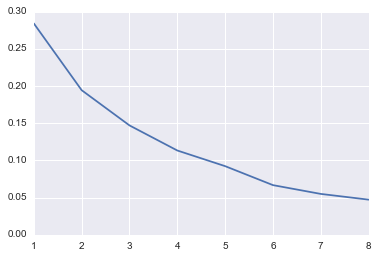

In [523]:
# add PCA to data_imputed
pca1 = PCA(n_components=8)
pca1.fit(X_train_std1)
plt.plot(range(1,9), pca1.explained_variance_ratio_);

In [524]:
pca1 = PCA(n_components=7, whiten=True)
pca1.fit(X_train_std1)

PCA(copy=True, n_components=7, whiten=True)

In [525]:
# first seven components expain over 95% of variance in the dataset
pca1.explained_variance_ratio_

array([ 0.28407653,  0.19436934,  0.14702505,  0.11330721,  0.09226792,
        0.06676229,  0.05494834])

In [526]:
sum(pca1.explained_variance_ratio_)

0.95275667521928509

In [495]:
# Training data --> PCA (transform)
X_trainpca1 = pd.DataFrame(pca1.transform(X_train_std1))

In [496]:
# Test data --> PCA (transform)
X_testpca1 = pd.DataFrame(pca1.transform(X_test_std1))

In [497]:
X_testpca1.head()

,0,1,2,3,4,5,6
0,-0.879,-0.255,0.055,-0.836,-1.151,-0.249,1.119
1,0.331,1.424,1.911,-1.055,0.968,0.480,0.642
2,-1.050,-0.570,0.429,-1.406,1.100,-2.295,0.528
3,-0.121,-0.964,-0.254,-0.500,-0.380,-0.755,2.795
4,1.823,-0.517,-0.791,0.996,-0.150,0.404,-1.220


In [498]:
# use same LR model as before
lr1pca = LogisticRegression(C= 1010.1010199999999, class_weight= None, penalty='l1')
lr1pca.fit(X_trainpca1, y_train1)

LogisticRegression(C=1010.10102, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0)

In [499]:
%timeit lr1pca.predict(X_testpca1)

The slowest run took 6.52 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 52.6 µs per loop


In [500]:
# accuracy with pca
lr1pca.score(X_testpca1, y_test1)

0.73509933774834435

In [501]:
# Precision / Recall / F1 with pca

pred1pca = lr1pca.predict(X_testpca1)
precision_recall_fscore_support(pred1pca, y_test1, average='binary')  

(0.55102040816326525, 0.59999999999999998, 0.57446808510638292, None)

#### Naive Bayes with data_imputed - pca

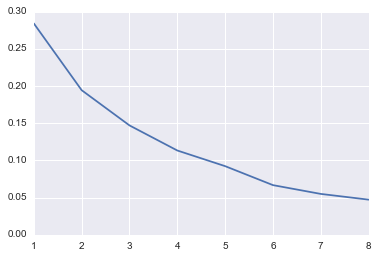

In [378]:
# add PCA to data_imputed
pca1 = PCA(n_components=8)
pca1.fit(X_train_std1)
plt.plot(range(1,9), pca1.explained_variance_ratio_);

In [416]:
# above, it looks like 2 or 6 -- so I will try 6 this time
pca1 = PCA(n_components=6, whiten=True)
pca1.fit(X_train_std1)

PCA(copy=True, n_components=6, whiten=True)

In [417]:
# first six components expain almost 90% of variance in the dataset
pca1.explained_variance_ratio_

array([ 0.28407653,  0.19436934,  0.14702505,  0.11330721,  0.09226792,
        0.06676229])

In [418]:
sum(pca1.explained_variance_ratio_)

0.89780833659754156

In [419]:
# Training data --> PCA (transform)
X_trainpca1 = pd.DataFrame(pca1.transform(X_train_std1))

In [420]:
# Test data --> PCA (transform)
X_testpca1 = pd.DataFrame(pca1.transform(X_test_std1))

In [421]:
X_trainpca1.head()

,0,1,2,3,4,5
0,-2.406,-0.017,-0.400,-0.321,0.700,-0.367
1,0.652,1.842,0.220,0.986,0.928,-0.230
2,0.339,0.073,1.405,0.381,0.456,-0.726
3,0.768,-0.657,-1.096,-0.312,0.178,1.135
4,0.476,-0.081,0.716,-0.732,-1.066,-0.724


In [532]:
gpca_nb1 = GaussianNB()
gpca_nb1.fit(X_trainpca1, y_train1)

GaussianNB()

In [533]:
%timeit gpca_nb1.predict(X_testpca1)

10000 loops, best of 3: 119 µs per loop


In [424]:
# accuracy with pca
gpca_nb1.score(X_testpca1, y_test1)

0.74172185430463577

In [425]:
# Precision / Recall / F1 with pca

pred1pca = gpca_nb1.predict(X_testpca1)
precision_recall_fscore_support(pred1pca, y_test1, average='binary')  

(0.55102040816326525, 0.61363636363636365, 0.58064516129032251, None)

## 7) Give your conclusions on the use of k-Means and PCA on the Diabetes dataset

Overall, there were many surprises. It is possible that the clusters I selected for data_imputed could have been better, as sometimes I second-guess finding the "elbow." Non-well-formed clusters could have lowered the performance of the Gaussian Naive Bayes in terms of accuracy. For both Logistic Regression and Naive Bayes, clustering increased runtime, which makes sense since we were adding another dimension. PCA also yielded surprising results, boosting Naive Bayes' accuracy (possibly due to assumed feature independence) and slightly lowering Logistic Regression's. Ultimately, it made Logistic Regression somewhat slower to run. In both cases, it diminished the models' interpretibility.